## Imports

In [349]:
import numpy as np
import pandas as pd
from sklearn import preprocessing,gaussian_process
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RBF
from scipy.stats import levene, bartlett
from datetime import datetime
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Data Wrangling
#### - Read dataset
#### - Transform and concat seperate datasets
#### - filter a subset dataframe from main dataframe 
    [specific 'Implementor' and 'Name of Project']

In [350]:
df = pd.read_csv('datasets/full_slippage_dataset.csv',encoding='utf-8', engine='python')
df['Contract Amount'] = df['Contract Amount'].astype(str)
df['No. of Days'] = df['No. of Days'].astype(str)
df = df.loc[df['Implementor']=='FREDEN CONSTRUCTION']
df = df.loc[df['Name of Project']=='Const. of 2-Storey Barangay Hall, Brgy. Kablon']
df.set_index('index', inplace=True)
df.index = pd.to_datetime(df.index)
pd.set_option('display.max_rows', df.shape[0]+1)

## Resampling
#### - Upsampling of each project's timeline from monthly to daily.
#### - Interpolation of continuous data.
##### [Polynomial, Spline, Gaussian Process Regression (*kriging*)]

In [351]:
proj_list = [proj for proj in df['Name of Project'].values]
project_list = []
for project in set(proj_list):
    rec_df = df.loc[df['Name of Project']==project]
    order = (rec_df.shape[0]) - 1
    if order >= 5: order = 5
    itpd_df = rec_df.resample("D").interpolate(method='spline', order=order)
    itpd_df = itpd_df.fillna(method='pad')
    itpd_df['Contract Amount'] = itpd_df['Contract Amount'].astype(float)
    itpd_df['No. of Days'] = itpd_df['No. of Days'].astype(int)
    project_list.append(itpd_df)

### Define Model
#### ***Gaussian Process Regression [Periodic,RBF]***

In [352]:
k0=WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))
k1=ConstantKernel(constant_value=2)*\
ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35,45))
k2=ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3))*\
RBF(length_scale=100.0, length_scale_bounds=(1, 1e4))
kernel_1 = k0 + k1 + k2
linear_model = gaussian_process.GaussianProcessRegressor(kernel=kernel_1, n_restarts_optimizer=10, normalize_y=True, alpha=0.0)

### Function for scoring
***score_model(X, y_test, y_pred)***    
returns: [adjusted R^2, Root Mean^2 Error]

In [353]:
def score_model(X, y_test, y_pred): 
    mse = 1/len(y_pred)*sum((y_test-y_pred)**2)
    rmse = np.sqrt(mse)
    ssr = sum((y_test - y_pred)**2)
    sst = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (ssr/sst)
    adj_r2 = 1-(1-r2)*(len(y_test)-1)/(len(y_test)-(len(X.columns))-1)
    
    return [adj_r2,rmse]

### Function for training and validating model
##### ***score_model(X,y,test_set=True)*** 
set ***test_set*** to **False** when spiltting for validation set       
returns: [X_train, X_test, y_train, y_test, y_pred]

In [354]:
def train_model(X_lately, X, y, test_set):
    for r in range(max_iter):  
        #Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=r)
        #Fitting
        model = linear_model.fit(X_train,y_train)
        if model.score(X_test, y_test) >= min_perc/100:
            y_test_pred = model.predict(X_test)
            y_pred = model.predict(X_lately)
            print('ADJ. R2: ', score_model(X, y_test, y_test_pred)[0],'\nRMSE: ', score_model(X, y_test, y_test_pred)[1])
            cross_val_score.append(score_model(X, y_test, y_test_pred)[0])
            return [X_train,X_test,y_train,y_test,y_pred]
        else: continue

## Modified Time Series Cross Validation
<!-- ![alt text|124x124,25%](img/tscv_nested.png "Title") -->

### Custom Gap Walk-Forward Cross Validation 
[adjusted test size per fold]

In [355]:
class CustomWalkForward:
    def __init__(self,test_size=test_size,gap=gap):
        self.test_size = test_size
        self.train_size = 1 - test_size
        self.gap = gap
        
    def split(self, df):
        X = df
        n = len(X)
        folds = int(math.ceil(n//(n*self.test_size)))
#         print(folds)
        q = int(n//folds)
        res = n%folds
        for k in range(1,folds+1):
            #NOTE: q*k returns the current size of n in the current fold
            train_range = int((q*k)*self.train_size)
            if k == folds:train_range = int((q*k)*self.train_size+res)
            train_set = X.head(train_range-self.gap)
            test_set = X[train_range:train_range+int((q*k)*self.test_size)]
            yield np.array(train_set.index), np.array(test_set.index)

ADJ. R2:  0.9997649976928438 
RMSE:  0.0132393988539728


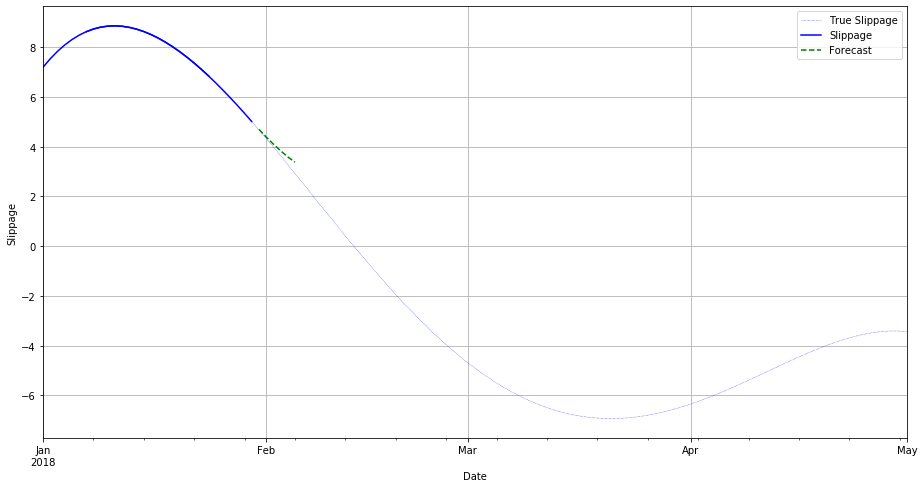

ADJ. R2:  0.9999674215832882 
RMSE:  0.02001695022361388


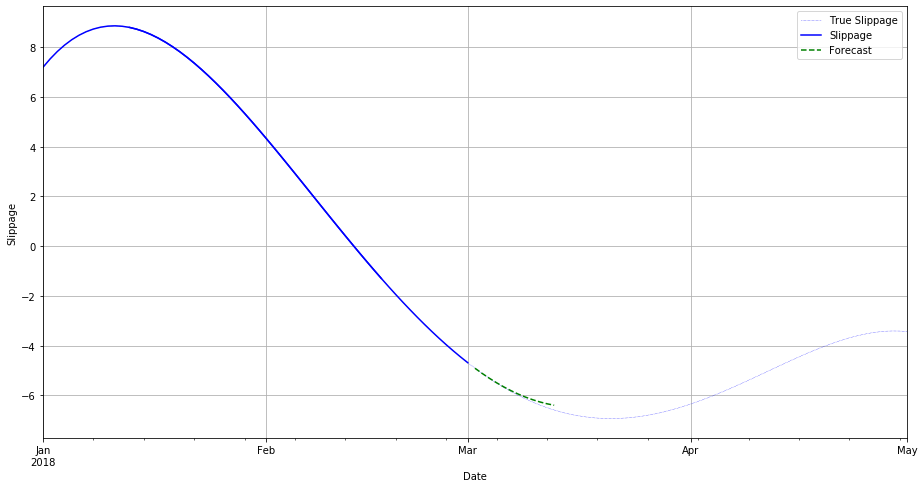

ADJ. R2:  0.9999606502275281 
RMSE:  0.020582439229963303


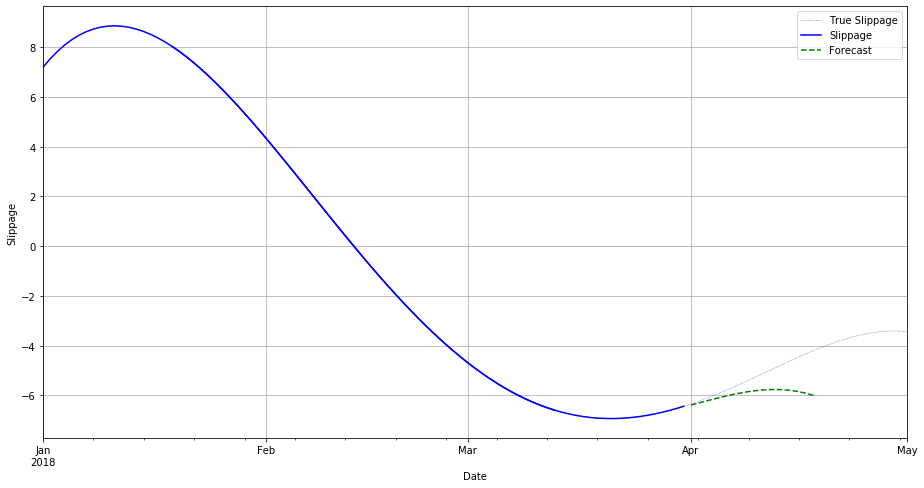

ADJ. R2:  0.9999830792989245 
RMSE:  0.015419059330941258


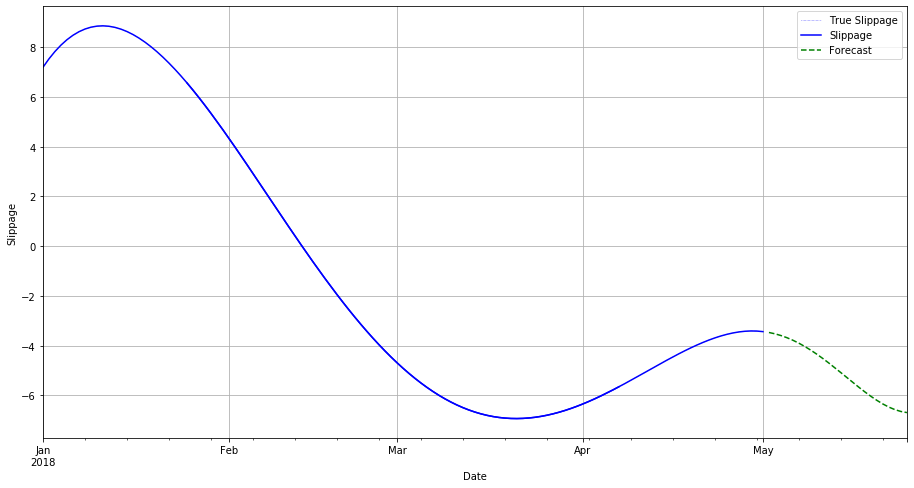

AVE. ADJ. R2:  0.9999190372006461


In [356]:
max_iter = 500 # number of iterations the model is being run
min_perc = 80 # lowest allowable adjusted r^2 score for model
cross_val_score = []
tscv = CustomWalkForward(test_size=0.2, gap=0)
itpdf = pd.concat(project_list)
itpdf = itpdf[['Slippage','% WT Plan']]

for train_index, test_index in tscv.split(itpdf):
#     print('TRAIN :',train_index, 'TEST :', test_index)
    cv_df = pd.concat(project_list)
    cv_df = cv_df[['Slippage','% WT Plan']]
    forecast_col = 'Slippage'
    X = cv_df
    scaler = preprocessing.StandardScaler()
    scaled_X = scaler.fit_transform(X)
    data = {'Slippage': scaled_X[:, 0], '% WT Plan': scaled_X[:, 1]}
    X = pd.DataFrame(data=data, index=X.index)
    X, X_lately = X.loc[train_index], X.loc[test_index]
      
    # Defining the lead feature
    cv_df['label'] = cv_df[forecast_col].head(len(train_index)+len(test_index)).shift(-(len(test_index)))
    
    cv_df.dropna(inplace=True)
    y = np.array(cv_df['label'])
        
    full_set = train_model(X_lately, X, y, test_set=True)
    X_train = full_set[0]
    X_test = full_set[1]
    y_train = full_set[2]
    y_test = full_set[3]
    y_pred = full_set[4]
    cv_df['Forecast'] = np.nan

    last_date = cv_df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day
    
    for i in y_pred:
        next_date = datetime.fromtimestamp(next_unix)
        next_unix+=one_day
        cv_df.loc[next_date] = [np.nan for _ in range(len(cv_df.columns)-1)] + [i]
    
    cv_df['label'] = cv_df['label'].shift(len(test_index))
    
    cv_df['Forecast'] = np.nan

    last_date = cv_df.iloc[-1].name
    last_unix = last_date.timestamp()
    one_day = 86400
    next_unix = last_unix + one_day
    
    for i in y_pred:
        next_date = datetime.fromtimestamp(next_unix)
        next_unix+=one_day
        cv_df.loc[next_date] = [np.nan for _ in range(len(cv_df.columns)-1)] + [i]

    itpdf['Slippage'].plot(label='True Slippage',linestyle=':',linewidth=0.5, color='b')
    cv_df['Slippage'].plot(color='b')
    cv_df['label'].plot(color='b',label='_nolegend_')
    cv_df['Forecast'].plot(linestyle='--', color='g')

    plt.legend(loc=1)
    plt.xlabel('Date')
    plt.ylabel('Slippage')
    plt.grid(True)
    plt.subplots_adjust(left=0, bottom=0, right=2, top=1.5,wspace=0, hspace=0)
    plt.show()
    
print('AVE. ADJ. R2: ', mean(cross_val_score))


In [357]:
# pd.set_option('display.max_rows', itpdf.shape[0]+1)
cv_df.head()

,Slippage,% WT Plan,label,Forecast
index,,,,
2018-01-01,7.200000,0.450000,NaN,NaN
2018-01-02,7.540024,0.486524,NaN,NaN
2018-01-03,7.837485,0.541418,NaN,NaN
2018-01-04,8.093969,0.615429,NaN,NaN
2018-01-05,8.311040,0.709272,NaN,NaN


In [358]:
cv_df.tail()

,Slippage,% WT Plan,label,Forecast
index,,,,
2018-05-21 16:00:00,NaN,NaN,NaN,-6.354326
2018-05-22 16:00:00,NaN,NaN,NaN,-6.479538
2018-05-23 16:00:00,NaN,NaN,NaN,-6.580777
2018-05-24 16:00:00,NaN,NaN,NaN,-6.654933
2018-05-25 16:00:00,NaN,NaN,NaN,-6.699231
